In [9]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from skimage import io

Ładujemy wszystkie oryginalne obrazy oraz ręcznie wykonane zaznaczenia do pamięci.

In [10]:
images = []
manuals = []
url = urlopen("https://www5.cs.fau.de/fileadmin/research/datasets/fundus-images/all.zip")
zipfile = ZipFile(BytesIO(url.read()))
names = zipfile.namelist()
for name in names:
    if name[-1] == '/':
      continue
    file = zipfile.open(name)
    img = io.imread(file, plugin='pil')
    if name.startswith("images/"):
        images.append(img)
    elif name.startswith("manual1/"):
        manuals.append(img)

Wizualizacja przykładowych 10 obrazów oryginalnych i z ręcznie zaznaczonymi naczyniami krwionośnymi.

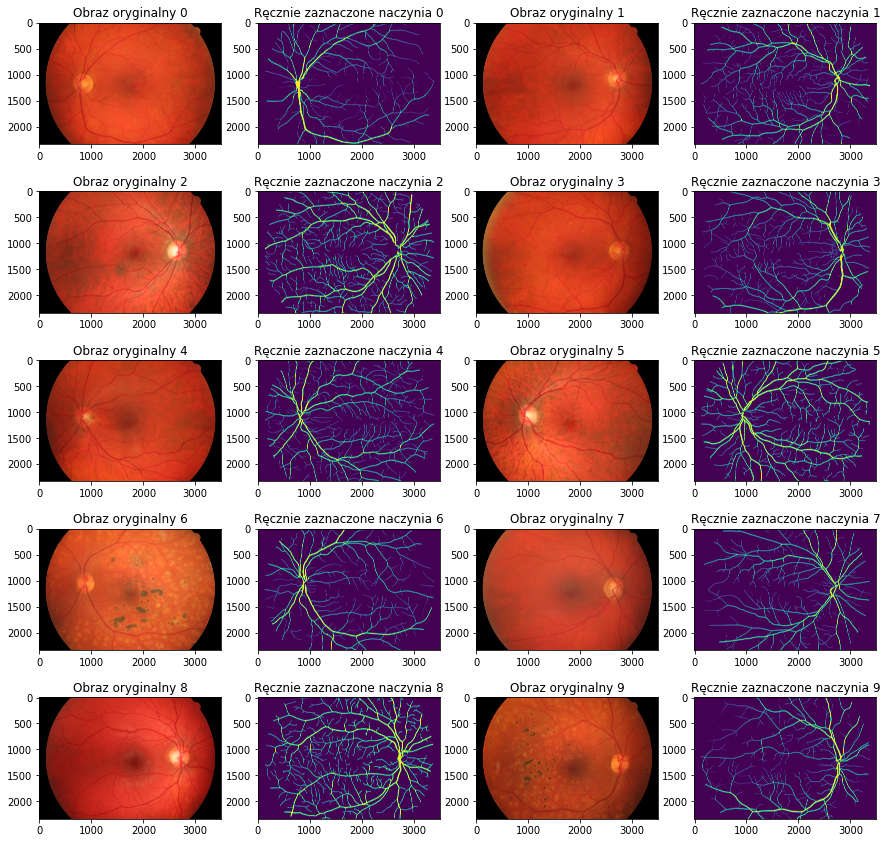

In [11]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if (i+1)%2:
        plt.title("Obraz oryginalny %d" % int(i/2))
        plt.imshow(images[int(i/2)])
    else:
        plt.title("Ręcznie zaznaczone naczynia %d" % int(i/2))
        plt.imshow(manuals[int(i/2)])
plt.show()

Przykładowy obraz, na którym będziemy wykonywali kolejne przekształcenia

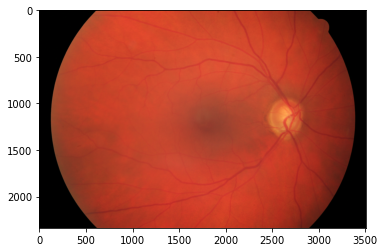

In [12]:
image = images[7]
plt.imshow(image)

Porównanie obrazu z włączonym tylko jednym kanałem koloru.

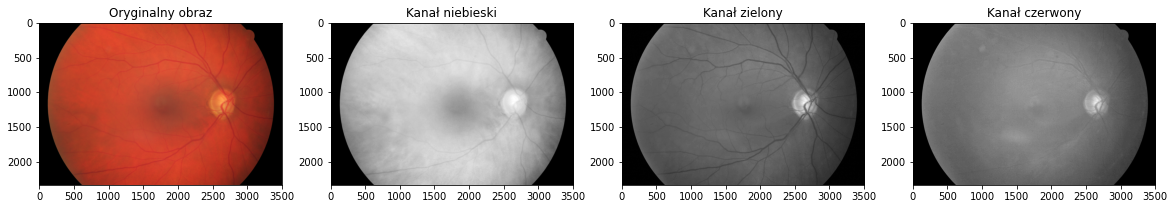

In [13]:
blue = image[:,:,0]
green = image[:,:,1]
red = image[:,:,2]

plt.figure(figsize=(20,12))
plt.subplot(141)
plt.imshow(image);
plt.title("Oryginalny obraz")
plt.subplot(142)
plt.imshow(blue, cmap='gray');
plt.title("Kanał niebieski")
plt.subplot(143)
plt.imshow(green, cmap='gray');
plt.title("Kanał zielony")
plt.subplot(144)
plt.imshow(red, cmap='gray');
plt.title("Kanał czerwony");

Jak powyżej widać najwięcej szczegółów na temat naczyń krwionośnych zawiera się w kanae zielonym więc z niego będziemy korzystać.  
Korzystamy z metody CLAHE (Contrast Limited Adaptive Equalization) celem zwiększenia kontratu na obrazie. 

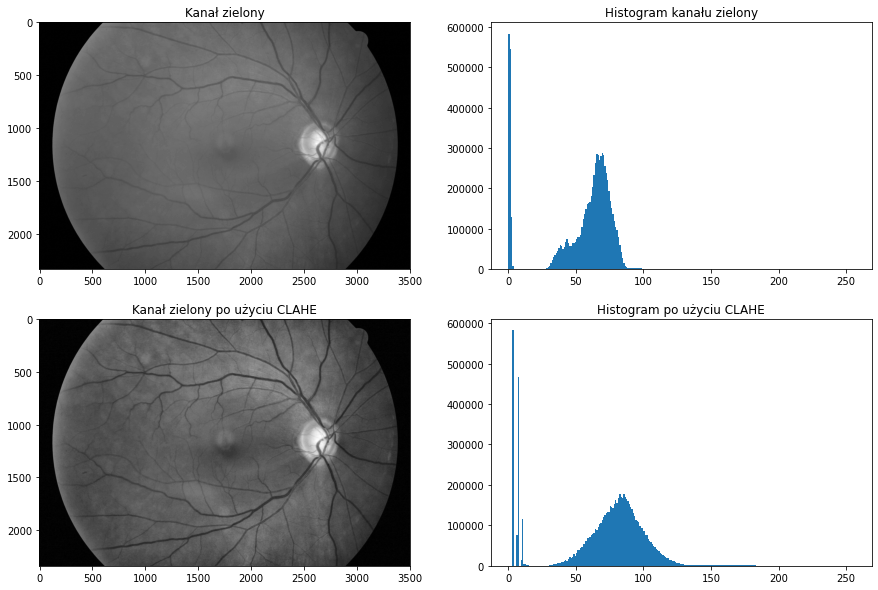

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(7,7))
green_CLAHE = clahe.apply(green)

fig=plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(green, cmap='gray')
plt.title("Kanał zielony")
plt.subplot(222)
plt.hist(green.ravel(),256,[0,256])
plt.title("Histogram kanału zielony")

plt.subplot(223)
plt.imshow(green_CLAHE, cmap='gray')
plt.title("Kanał zielony po użyciu CLAHE")
plt.subplot(224)
plt.hist(green_CLAHE.ravel(),256,[0,256])
plt.title("Histogram po użyciu CLAHE")

plt.show()

Oddzielamy tło naczyń krwionośnych za pomocą przekstałceń morfologicznych.

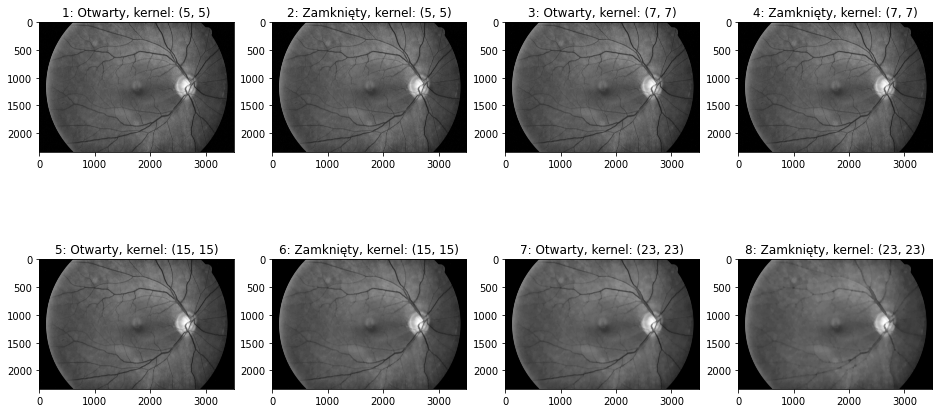

In [15]:
kernel_sizes = [5,7,15,23]
kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

morphology_steps = [green_CLAHE.copy()]
for kernel in kernels:
    image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
    image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
    morphology_steps.extend([image_opened, image_closed])

fig=plt.figure(figsize=(16, 8))
rows = 2
columns = len(kernels)
for i in range(1, len(morphology_steps)):
    fig.add_subplot(rows, columns, i)
    plt.imshow(morphology_steps[i], cmap='gray')
    kernel_size = kernel_sizes[math.ceil(i/2)-1]
    if i%2==1:
        plt.title("%d: Otwarty, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
    else:
        plt.title("%d: Zamknięty, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
plt.show()

Odejmujemy tło z naszego obrazu.

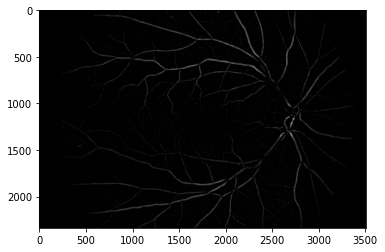

In [17]:
extracted_vessels = cv2.subtract(morphology_steps[-1],green_CLAHE)
plt.imshow(extracted_vessels, cmap='gray')

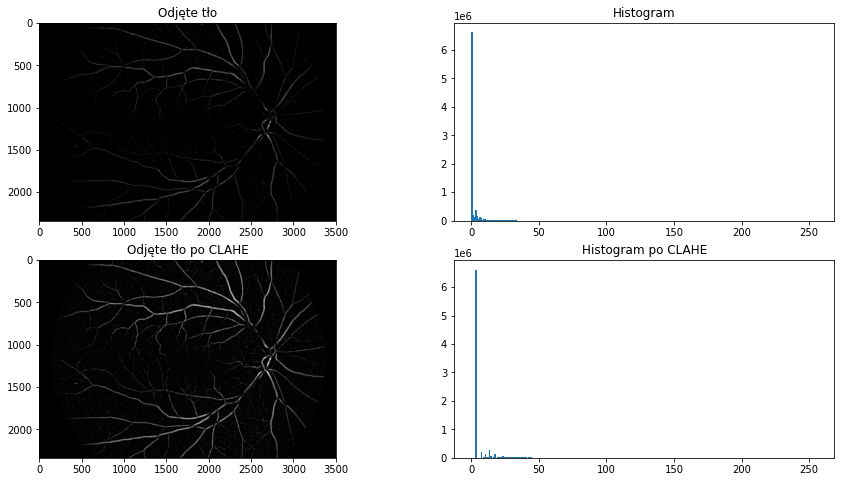

In [18]:
extraced_vessels_CLAHE = clahe.apply(extracted_vessels)

fig=plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.imshow(extracted_vessels, cmap='gray')
plt.title("Odjęte tło")
plt.subplot(222)
plt.hist(extracted_vessels.ravel(),256,[0,256])
plt.title("Histogram")

plt.subplot(223)
plt.imshow(extraced_vessels_CLAHE, cmap='gray')
plt.title("Odjęte tło po CLAHE")
plt.subplot(224)
plt.hist(extraced_vessels_CLAHE.ravel(),256,[0,256])
plt.title("Histogram po CLAHE")

plt.show()

Stosujemy treshholding celem wyróżnienia naczyń

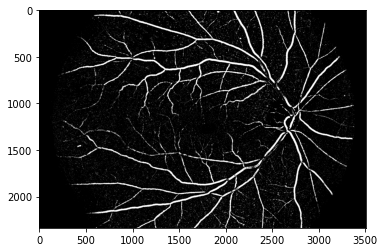

In [19]:
ret,extracted_vessels_CLAHE_thresh = cv2.threshold(extraced_vessels_CLAHE,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_CLAHE_thresh,cmap='gray')

W tym momencie może pojawić się "noise" na obrazku, w tym przykładzie aż tak go nie widać, lecz będziemy go usuwać, żeby inne obrazy z tego mogły skorzystać.

In [20]:
noise = np.ones(extraced_vessels_CLAHE.shape[:2], dtype="uint8") * 255

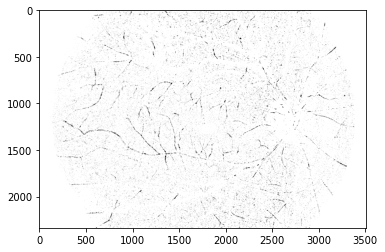

In [21]:
contours, hierarchy = cv2.findContours(extracted_vessels_CLAHE_thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if cv2.contourArea(contour) <= 200:
        cv2.drawContours(noise, [contour], -1, 0, -1)
plt.imshow(noise, cmap='gray')

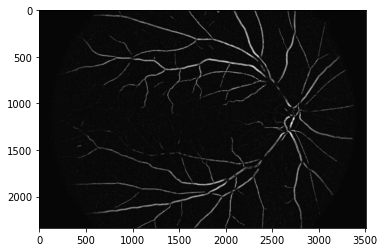

In [22]:
extracted_vessels_without_noise = cv2.bitwise_and(extraced_vessels_CLAHE, extraced_vessels_CLAHE, mask=noise)
plt.imshow(extracted_vessels_without_noise, cmap='gray')

Po usunięciu 'noise' ponownie używamy tresholdingu.

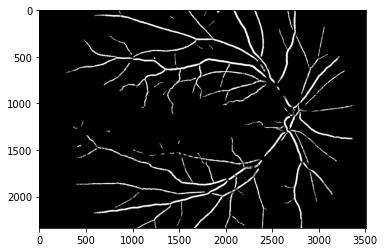

In [23]:
ret,extracted_vessels_without_noise_tresh = cv2.threshold(extracted_vessels_without_noise,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_without_noise_tresh, cmap='gray')

Łaczymy cały powyższy proces w funkcje celem pokazania wyników na większej liczbie obrazów.

In [24]:
def vessels(image, kernel_sizes = [5,7,15,21], thresh_val=20, max_noise_area=200):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    green = image[:,:,1]
    green_CLAHE = clahe.apply(green)
    
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

    morphology_steps = [green_CLAHE.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([image_opened, image_closed])

    extracted_vessels = cv2.subtract(morphology_steps[-1],green_CLAHE)
    extracted_vessels_CLAHE = clahe.apply(extracted_vessels)
    _, extracted_vessels_CLAHE_thresh = cv2.threshold(extracted_vessels_CLAHE,thresh_val,255,cv2.THRESH_BINARY)
    
    noise = np.ones(extracted_vessels_CLAHE_thresh.shape[:2], dtype="uint8") * 255

    contours, hierarchy = cv2.findContours(extracted_vessels_CLAHE_thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= max_noise_area:
            cv2.drawContours(noise, [contour], -1, 0, -1)

    extracted_vessels_without_noise = cv2.bitwise_and(extracted_vessels_CLAHE, extracted_vessels_CLAHE, mask=noise)
    _, extracted_vessels_without_noise_tresh = cv2.threshold(extracted_vessels_without_noise,thresh_val,255,cv2.THRESH_BINARY)
    return extracted_vessels_without_noise_tresh

In [26]:
vessels_ready = [vessels(image) for image in images]

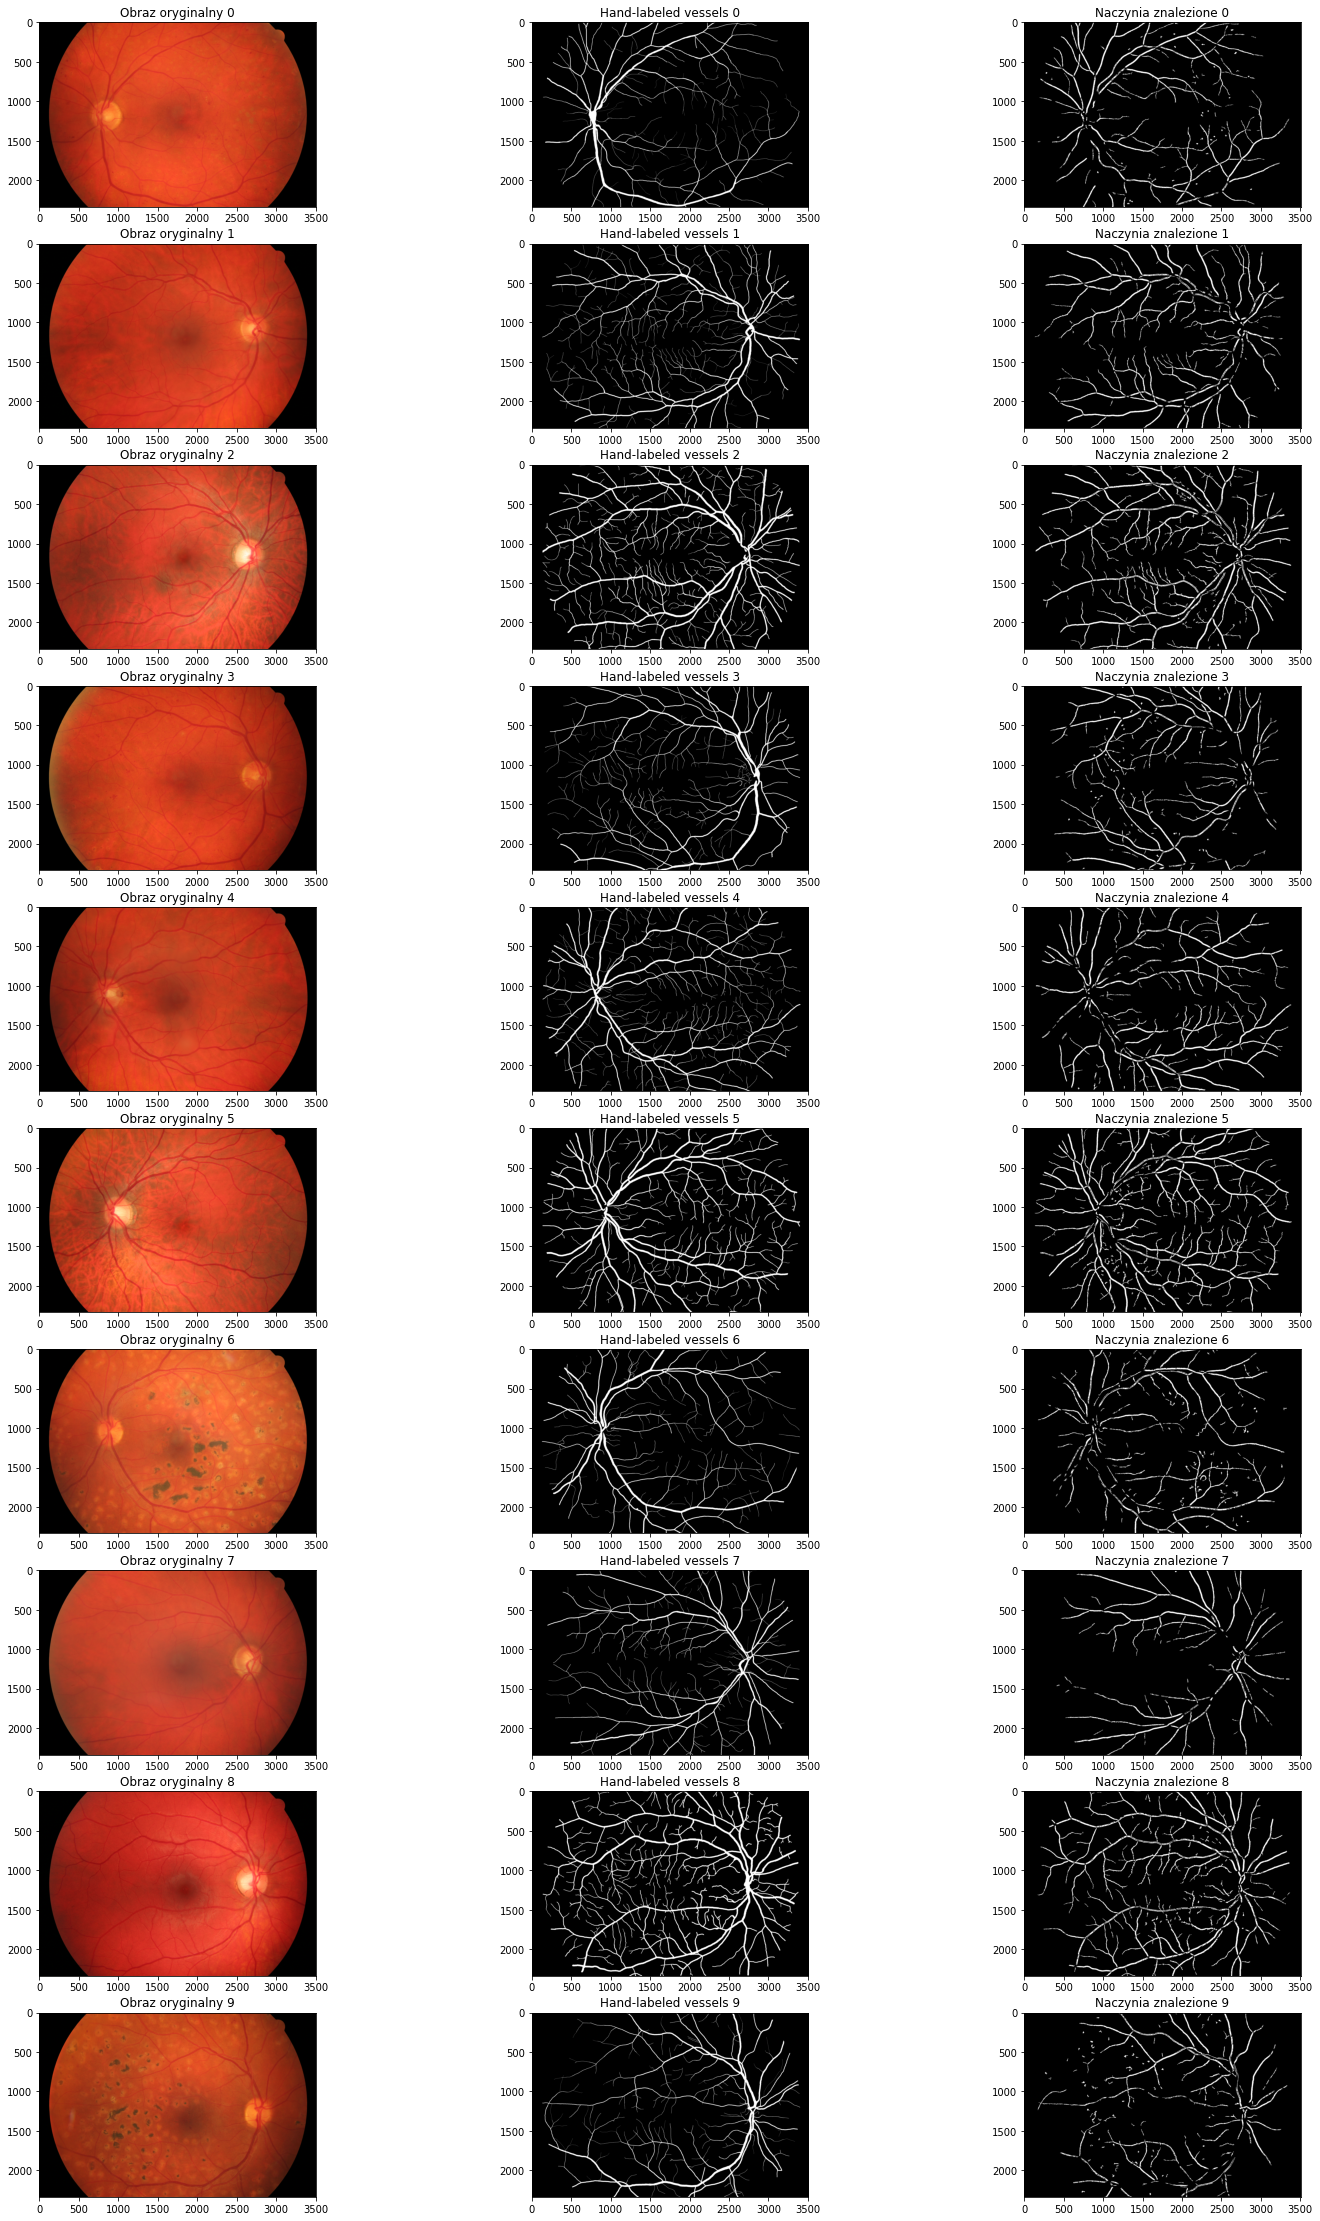

In [27]:
fig=plt.figure(figsize=(25, 40))
columns = 3
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i%3==0:
        plt.title("Obraz oryginalny %d" % int(i/3))
        plt.imshow(images[int(i/3)])
    elif i%3==1:
        plt.title("Hand-labeled vessels %d" % int(i/3))
        plt.imshow(manuals[int(i/3)], cmap='gray')
    else:
        plt.title("Naczynia znalezione %d" % int(i/3))
        plt.imshow(vessels_ready[int(i/3)], cmap='gray')
plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

Funkcje do liczenia statystyk

In [29]:
def geo_mean(val1, val2):
    return (val1*val2)**(1.0/2)

def get_metrics(test, pred):
    conf = confusion_matrix(test.flatten(), pred.flatten())
    TN, FP, FN, TP = conf.ravel()
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = geo_mean(sensitivity, specificity)
    
    return (accuracy, sensitivity, specificity, geo_mean_val)

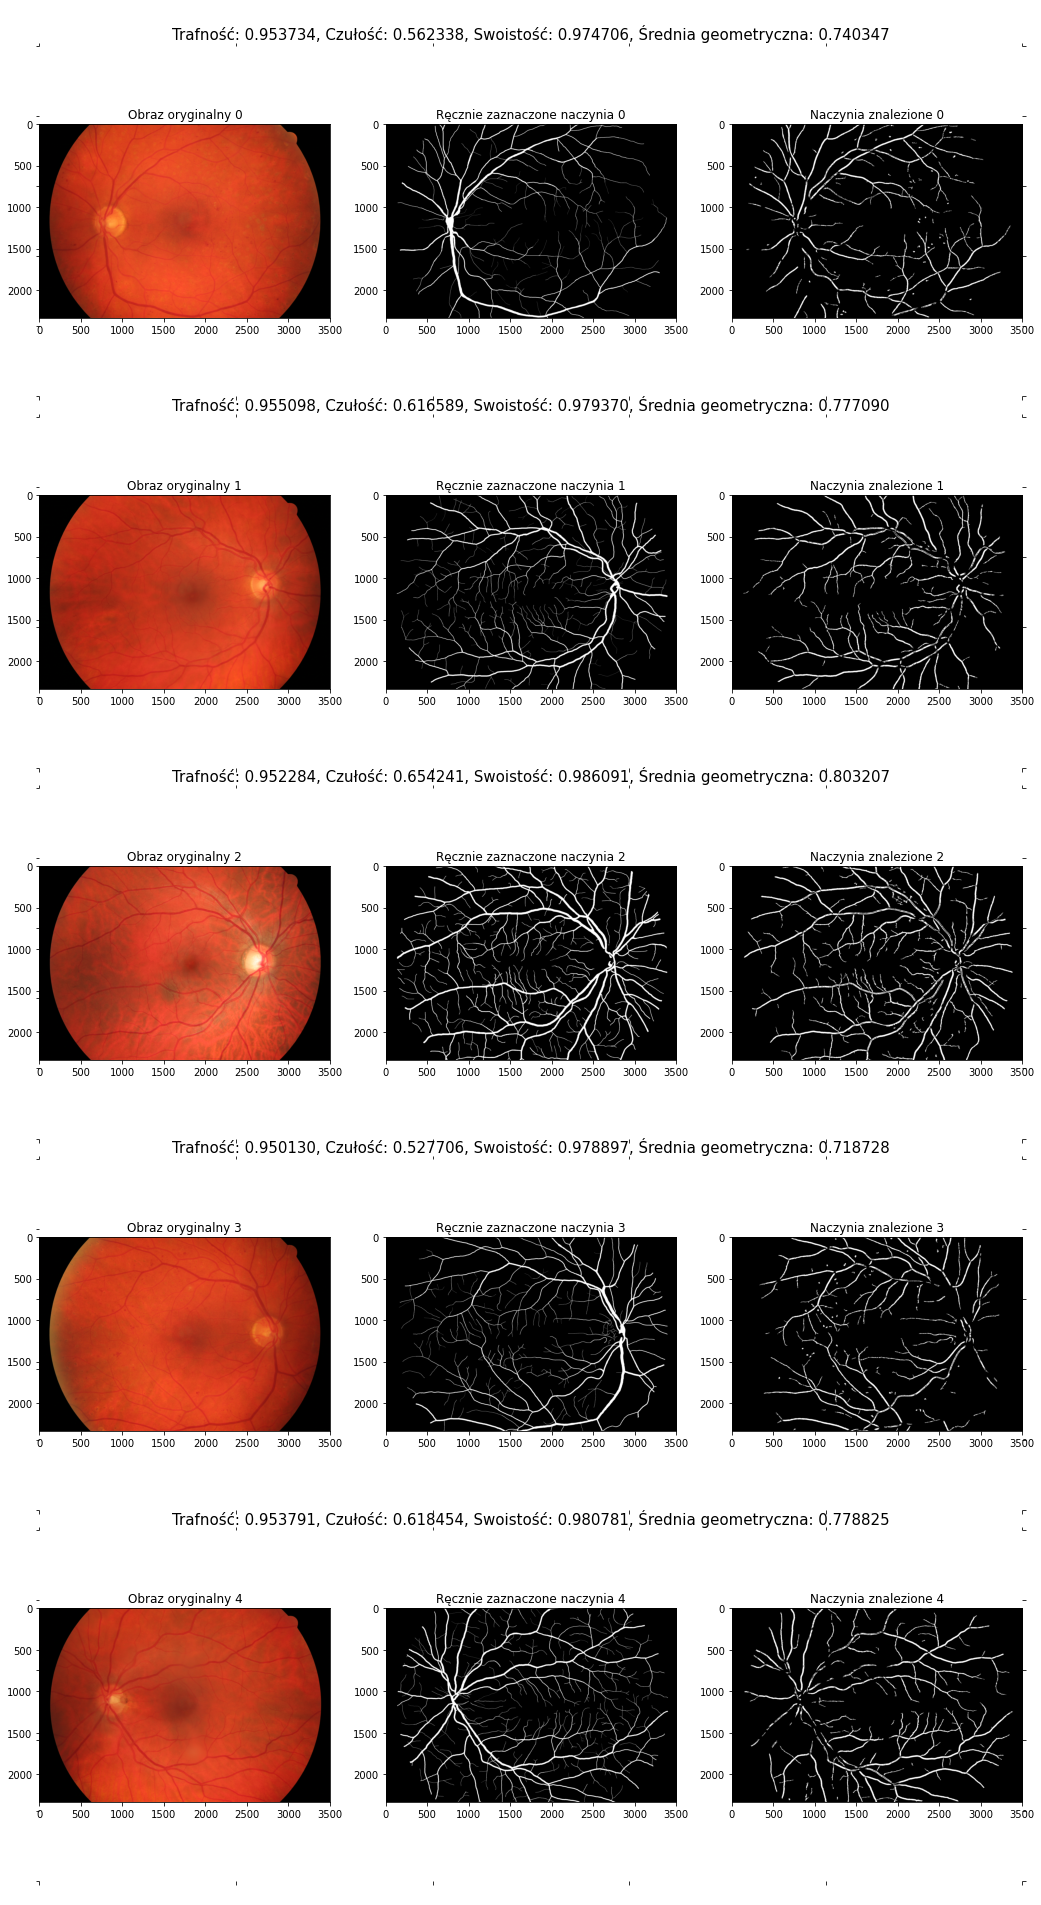

In [36]:
columns = 3
rows = 5

fig, big_axes = plt.subplots( figsize=(15, 26) , nrows=rows, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("\nTrafność: %f, Czułość: %f, Swoistość: %f, Średnia geometryczna: %f"%get_metrics(manuals[row-1], vessels_ready[row-1]), fontsize=15)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i%3==0:
        plt.title("Obraz oryginalny %d" % int(i/3))
        plt.imshow(images[int(i/3)])
    elif i%3==1:
        plt.title("Ręcznie zaznaczone naczynia %d" % int(i/3))
        plt.imshow(manuals[int(i/3)], cmap='gray')
    else:
        plt.title("Naczynia znalezione %d" % int(i/3))
        plt.imshow(vessels_ready[int(i/3)], cmap='gray')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig('results.png', dpi=200)
plt.show()